In [1]:
from process_data import plot_emg, process_signal

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../')
from utils.signal_processing import *
import pyemgpipeline as pep

In [3]:
def data_from_files(data, metadata, electrodes=[[3,2],[7,6]]):
    sess_data = pd.read_csv(data,header=None)
    sess_metadata = pd.read_csv(metadata, names=['start_time','category'])
    category_instances = {'REST':[]}
    for i, row in sess_metadata.iterrows():
        category = row['category'].strip()
        if not category == 'REST':
            continue
        next_category = sess_metadata.iloc[i + 1]['category'].strip()
        rest_start = row['start_time']
        cat_start = sess_metadata.iloc[i + 1]['start_time']
        cat_end = sess_metadata.iloc[i + 4]['start_time'] if i+4 < (len(sess_metadata) - 1) else sess_data.iloc[-1][0]
        all_electrodes = []
        for electrode in electrodes:
            all_electrodes += electrode
        channels_rest = sess_data.loc[(sess_data[0] >= rest_start) & (sess_data[0] < cat_start)].iloc[:,all_electrodes]
        channels_cat = sess_data.loc[(sess_data[0] >= cat_start) & (sess_data[0] < cat_end)].iloc[:,all_electrodes]
        instances_rest = pd.DataFrame()
        instances_cat = pd.DataFrame()
        for i,pair in enumerate(electrodes):
            instances_rest[f'e{i+1}'] = tripolar_laplacian(channels_rest[pair[0]],pair[1])
            instances_cat[f'e{i+1}'] = tripolar_laplacian(channels_cat[pair[0]],pair[1])
        category_instances['REST'].append(instances_rest)
        if next_category not in category_instances:
            category_instances[next_category] = []
        category_instances[next_category].append(instances_cat)
    return category_instances

In [4]:
sess2_data = 'test_sess2_data.txt'
sess2_metadata = 'test_sess2_metadata.txt'
sess2 = pd.read_csv(sess2_data, header=None)
sess2_md = pd.read_csv(sess2_metadata, header=None)

In [5]:
sess2_md

,0,1
0,2.601025e+06,REST
1,2.601029e+06,INDEX UP
2,2.601030e+06,HOLD
3,2.601034e+06,STOP
4,2.601035e+06,REST
...,...,...
135,2.601366e+06,STOP
136,2.601367e+06,REST
137,2.601371e+06,SNAP
138,2.601372e+06,HOLD


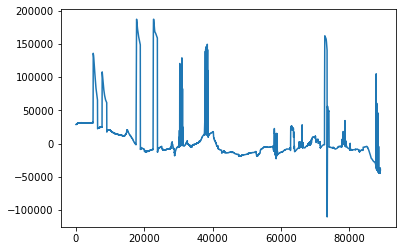

In [6]:
plt.plot(sess2[1])

In [7]:
category_instances = data_from_files(sess2_data,sess2_metadata,electrodes=[[1,2],[3,4],[5,6],[7,8]])

In [8]:
category_instances.keys()

dict_keys(['REST', 'INDEX UP', 'CLENCH FIST', 'PINCH PINCH', 'THUMB OUT', 'WRIST UP', 'WRIST DOWN', 'SNAP'])

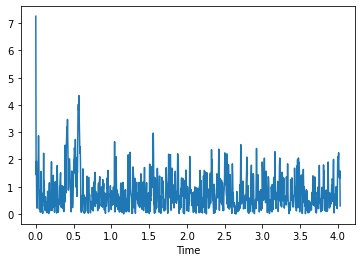

In [9]:
for i in range(1):
    plot_emg(cat_dict=category_instances, category='REST', instance=i, electrode='e3', plot=True)

In [10]:
import os
print(os.getcwd())

/Users/aidantruel/EMGMouse/Project-TNNI-ACD/Project-Data


In [11]:
data_dir = '../data/emg_recordings/'

In [12]:
sess3_data = data_dir + 'test_sess3_data.txt'
sess3_metadata = data_dir + 'test_sess3_metadata.txt'
sess4_data = data_dir + 'test_sess4_data.txt'
sess4_metadata = data_dir + 'test_sess4_metadata.txt'
sess5_data = data_dir + 'test_sess5_data.txt'
sess5_metadata = data_dir + 'test_sess5_metadata.txt'

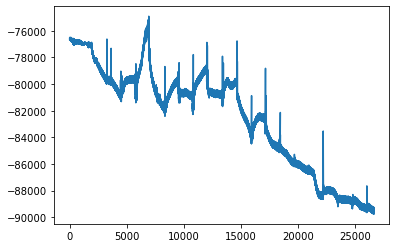

In [13]:
sess3 = pd.read_csv(sess3_data,header=None)
plt.plot(sess3[1])

In [14]:
category_instances = data_from_files(sess3_data,sess3_metadata,electrodes=[[1,2],[3,4],[5,6],[7,8]])

In [15]:
category_instances.keys()

dict_keys(['REST', 'WRIST DOWN', 'SNAP', 'CLENCH FIST', 'WRIST UP'])

In [16]:
#Notch filter with Q=30 gives good SNR, makes snaps very visible in all conditions

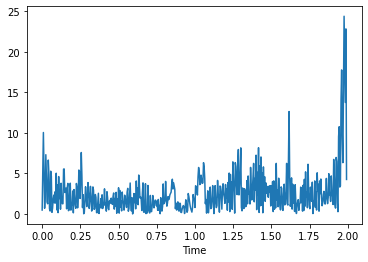

In [17]:
emg =  plot_emg(cat_dict=category_instances, category='REST', instance=0, electrode='e2',low=5,high=124,Q=30, plot=True)

In [18]:
def find_peaks(cat_dict, category, instance):
    peaks = []
    for i in range(4):
        emg = plot_emg(cat_dict,category,instance, f'e{i+1}',plot=False)
        peak = np.max(emg.data)
        peaks.append(peak)
    return np.array(peaks)

In [19]:
def compute_amp_factor(sample, reference):
    amp_factors = []
    for i in range(len(sample)):
        amp_factor = sample[i]/reference[i]
        amp_factors.append(amp_factor)
    return np.mean(amp_factors)

In [31]:
rest_pks = find_peaks(category_instances, 'REST', 1)
rest_pks

array([52.65208625, 10.60332512, 35.11497801, 27.01502054])

In [32]:
clench_pks = find_peaks(category_instances, 'CLENCH FIST', 0)
clench_pks

array([ 986.82121701,  308.87029512, 1264.0291358 ,  145.60652118])

In [33]:
amp_facts = compute_amp_factor(clench_pks,rest_pks)
amp_facts

22.31464271289489

In [34]:
for i in range(5):
    clench_pks = find_peaks(category_instances, 'CLENCH FIST', i)
    print(compute_amp_factor(clench_pks,rest_pks))

22.31464271289489
26.243279936136496
23.437905541217372
9.956003700198616
9.890343974984589


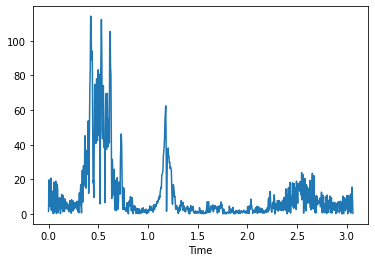

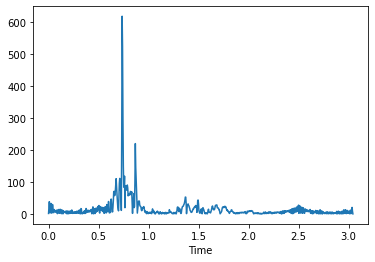

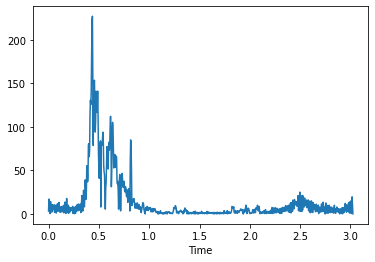

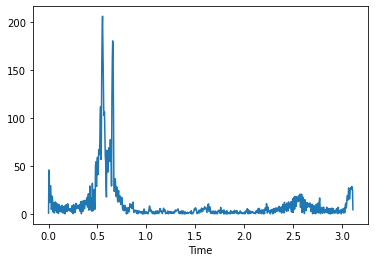

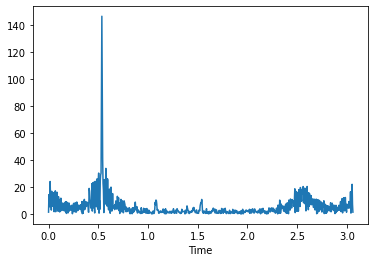

In [35]:
for i in range(5):
    plot_emg(cat_dict=category_instances, category='WRIST UP', instance=i, electrode='e2',low=5,high=124,Q=30, plot=True)